# Modelo
Este es el modelo que mejor funcionó para el Tomate, sin embargo, se pueden incluir todos los productos quitando la linea que filtra únicamente el producto Tomate

In [5]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ----------------------------
# Carga y filtrado inicial
# ----------------------------
df = pd.read_csv('/content/og_exogenas.csv', parse_dates=['Fecha'], index_col='Fecha')
if df.index.tz:
    df.index = df.index.tz_localize(None)

#df = df[df['Producto'] == 'Tomate Saladete']
df = df[df['Origen'] == 'Bodega']

# -----------------------------------
# Construcción de la serie mensual
# -----------------------------------
# 'y' = merma (suma mensual de Cajas)
ts = df['Cajas'].resample('MS').sum().to_frame('y')

# Exógenas promediadas mensualmente
exog = df[['temp_c', 'pres', 'gas', 'humidity', 'precip', 'cost_mwh', 'price_index']] \
         .resample('MS').mean().dropna()

# Unir merma + exógenas
data = ts.join(exog, how='inner')

# --------------------------------------------
# Crear columna de lag (1 mes atrás) y diff
# --------------------------------------------
# Lag 1
data['merma_lag1'] = data['y'].shift(1)

# (Opcional) diferencia absoluta mes a mes
data['merma_diff'] = data['y'] - data['y'].shift(1)

# Eliminar primera fila (NaN en lag/diff)
data = data.dropna(subset=['merma_lag1', 'merma_diff'])

# ---------------------------------------------------------
# Definir X_full (exógenas + lag + diff) e y_full (merma)
# ---------------------------------------------------------
# Las features (incluyen exógenas más lag/diff)
features = list(exog.columns) + ['merma_lag1', 'merma_diff']
X_full = data[features]
y_full = data['y']

# -------------------------------------------------------
# separar en train/test (manteniendo los últimos h meses)
# -------------------------------------------------------
h = 3
X_train, X_test = X_full[:-h], X_full[-h:]
y_train, y_test = y_full[:-h], y_full[-h:]

# Índice de fechas para graficar
fechas_test = X_test.index  # DatetimeIndex (por ej. ['2024-01-01', '2024-02-01', '2024-03-01'])


# Este fue el mejor modelo, la busqueda de hiperparámetros se hizo con un search grid
meta_model = LinearRegression()

# XGBoost con hiperparámetros óptimos
xgb_best = XGBRegressor(
    learning_rate=0.3,
    max_depth=3,
    n_estimators=10,
    objective='reg:absoluteerror', # Usar 'reg:absoluteerror' como pediste
    random_state=42
)

#RandomForest mejores hiperpa´rametros
rf_best = RandomForestRegressor(
    max_depth=3,
    max_features='sqrt',
    n_estimators=50,
    random_state=42
)

# Configurar StackingRegressor con modelos base RF y XGB (usamos los ya optimizados)
stacking_reg = StackingRegressor(
    estimators=[('rf', rf_best), ('xgb', xgb_best)],
    final_estimator=meta_model,
    cv=3
)

# Entrenar el modelo de stacking

stacking_reg.fit(X_train, y_train)

# Obtener predicciones del stacking en el conjunto de prueba
y_pred_stack = stacking_reg.predict(X_test)


# Evaluar desempeño de stacking y blending
stack_mae = mean_absolute_error(y_test, y_pred_stack)
stack_rmse = mean_squared_error(y_test, y_pred_stack)
print(f"Stacking - MAE: {stack_mae:.2f}, RMSE: {stack_rmse:.2f}")


Stacking - MAE: 1199.44, RMSE: 1691440.90


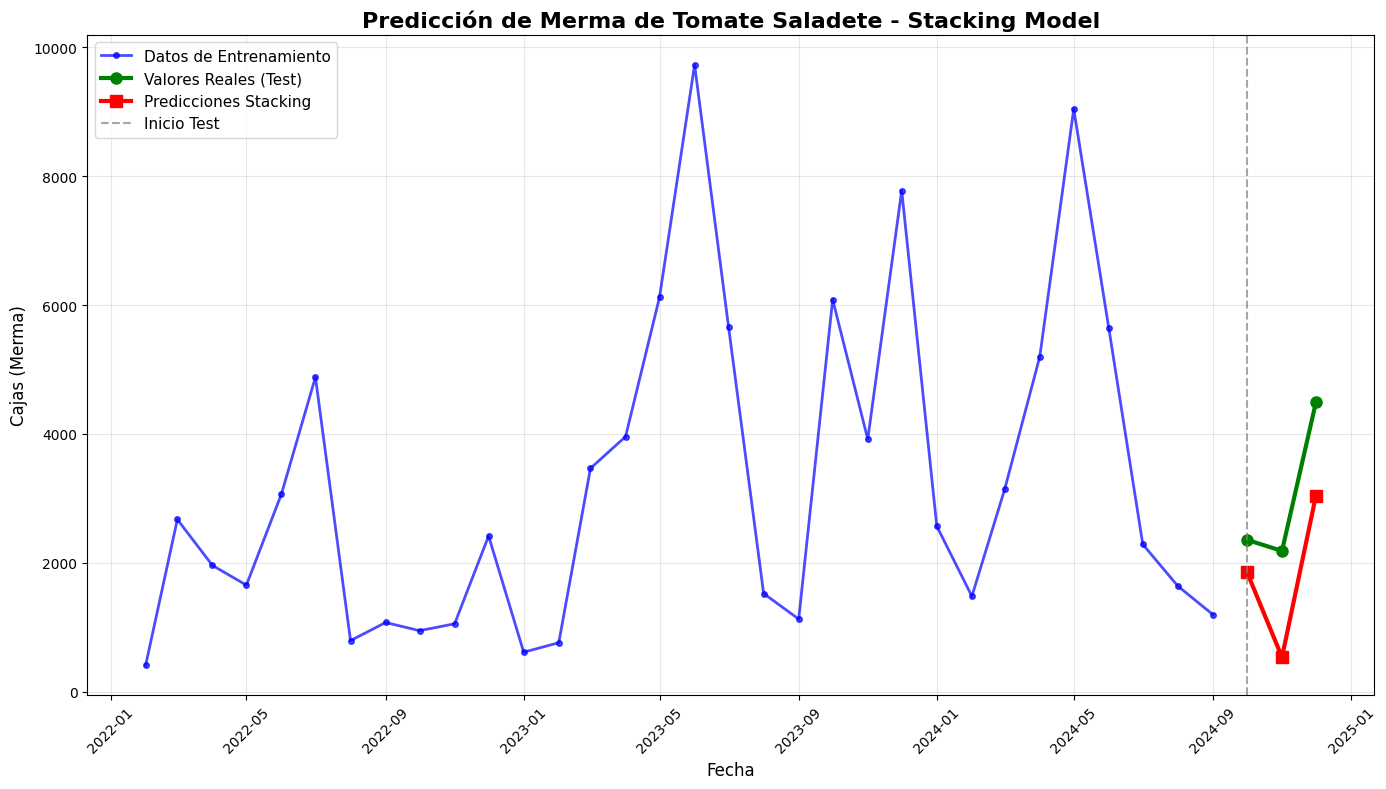

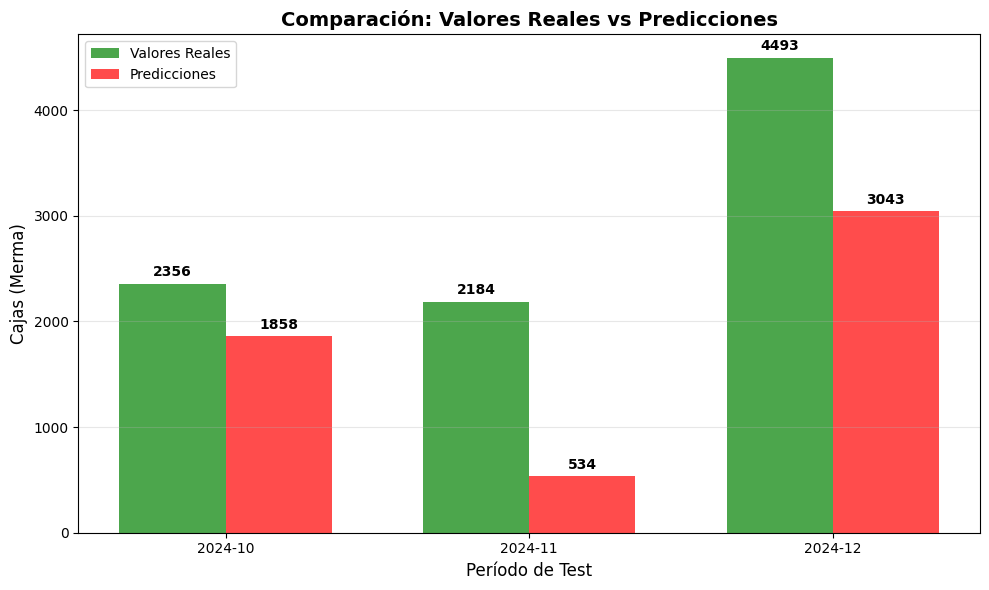

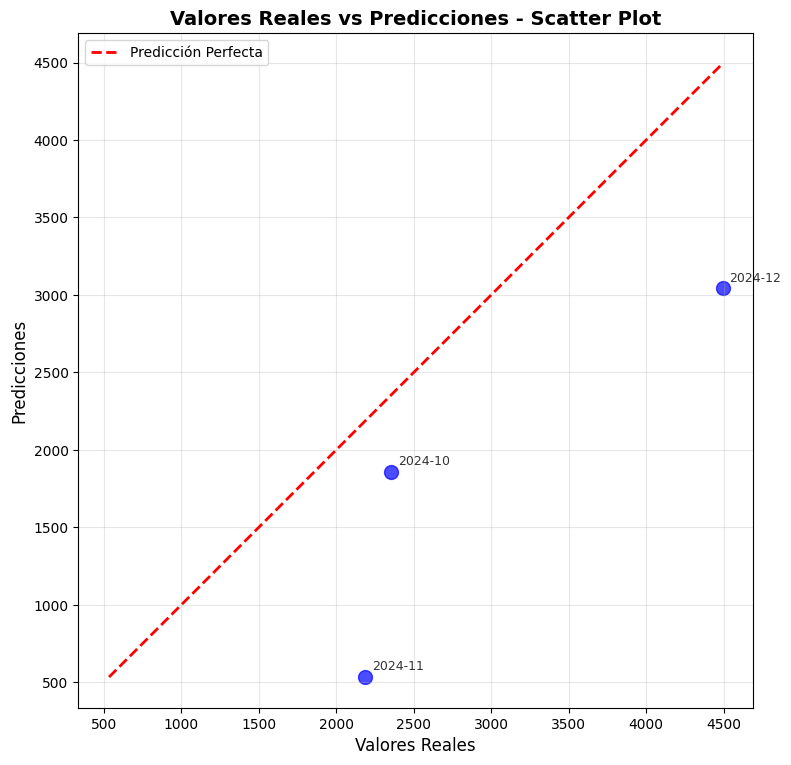

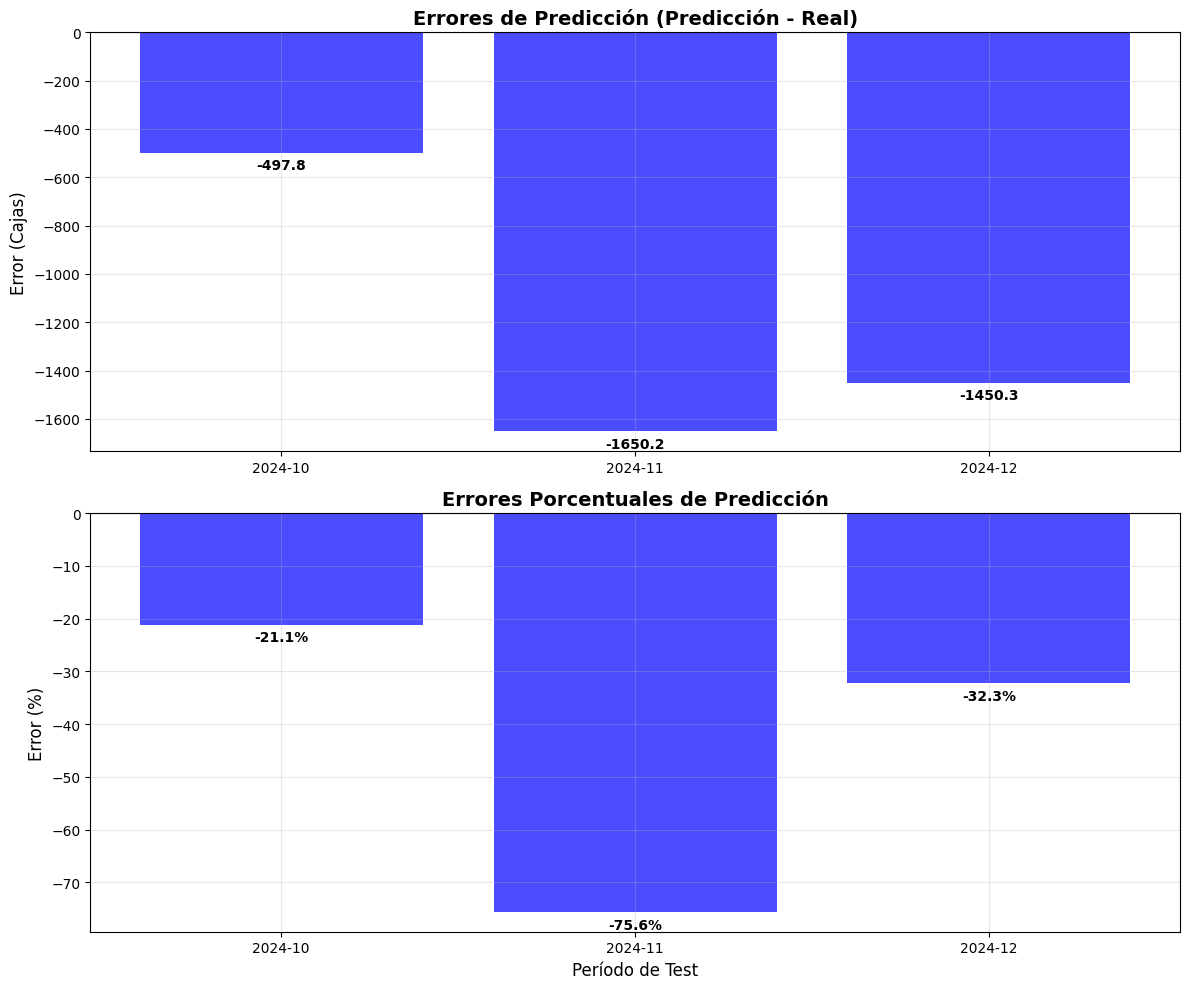


RESUMEN DE RESULTADOS
MAE (Mean Absolute Error): 1199.44 cajas
RMSE (Root Mean Square Error): 1691440.90 cajas
Error promedio: -1199.44 cajas
Error porcentual promedio: 42.99%

Detalle por período:
2024-10: Real=2356, Pred=1858, Error=-497.8 (-21.1%)
2024-11: Real=2184, Pred=534, Error=-1650.2 (-75.6%)
2024-12: Real=4493, Pred=3043, Error=-1450.3 (-32.3%)


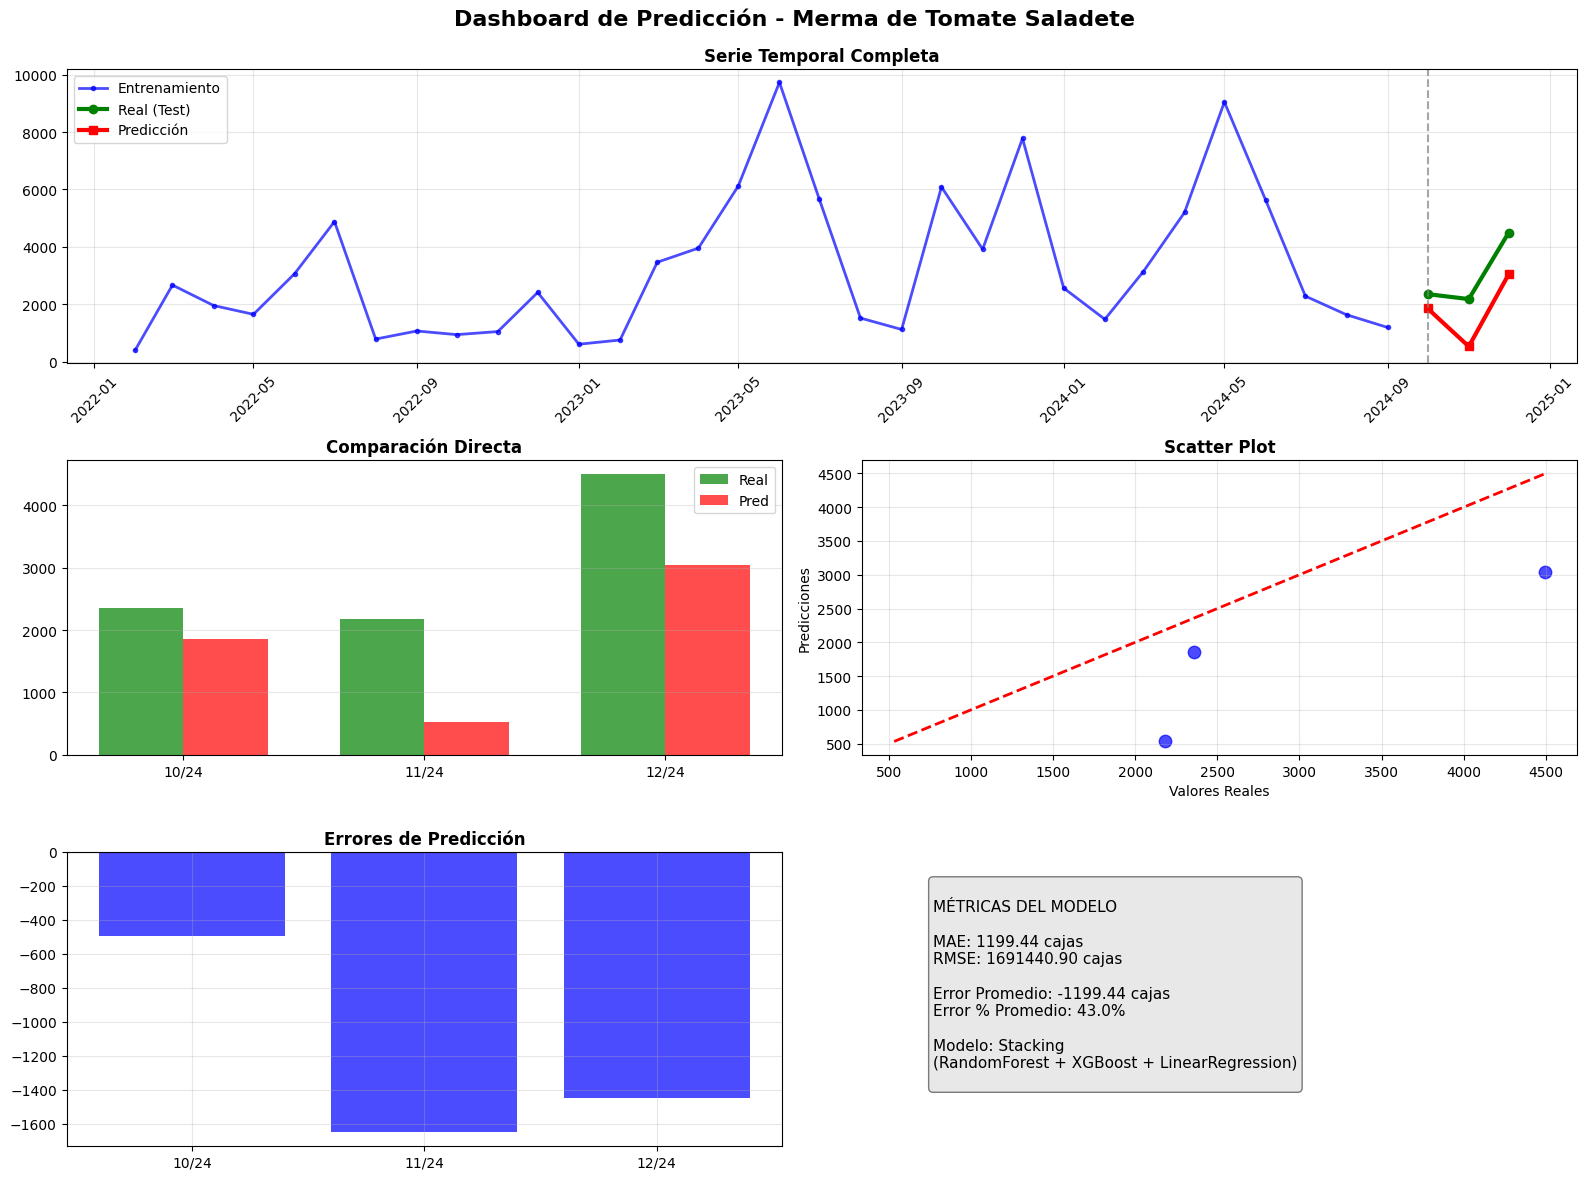

In [6]:
# Importar matplotlib si no está ya importado
import matplotlib.pyplot as plt
import numpy as np

# Configurar el estilo de las gráficas
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ----------------------------
# 1. Gráfica de Serie de Tiempo
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Plotear los datos de entrenamiento
ax.plot(y_train.index, y_train.values, 'o-', color='blue', alpha=0.7,
        label='Datos de Entrenamiento', linewidth=2, markersize=4)

# Plotear los valores reales del test
ax.plot(fechas_test, y_test.values, 'o-', color='green',
        label='Valores Reales (Test)', linewidth=3, markersize=8)

# Plotear las predicciones
ax.plot(fechas_test, y_pred_stack, 's-', color='red',
        label='Predicciones Stacking', linewidth=3, markersize=8)

# Añadir línea vertical para separar train/test
ax.axvline(x=fechas_test[0], color='gray', linestyle='--', alpha=0.7,
           label='Inicio Test')

# Configurar la gráfica
ax.set_title('Predicción de Merma de Tomate Saladete - Stacking Model',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Cajas (Merma)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Rotar las fechas para mejor visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------
# 2. Gráfica de Comparación Directa
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Crear índice numérico para el eje x
x_pos = np.arange(len(fechas_test))
width = 0.35

# Crear barras comparativas
bars1 = ax.bar(x_pos - width/2, y_test.values, width,
               label='Valores Reales', color='green', alpha=0.7)
bars2 = ax.bar(x_pos + width/2, y_pred_stack, width,
               label='Predicciones', color='red', alpha=0.7)

# Añadir valores en las barras
for i, (real, pred) in enumerate(zip(y_test.values, y_pred_stack)):
    ax.text(i - width/2, real + max(y_test.values)*0.01, f'{real:.0f}',
            ha='center', va='bottom', fontweight='bold')
    ax.text(i + width/2, pred + max(y_test.values)*0.01, f'{pred:.0f}',
            ha='center', va='bottom', fontweight='bold')

# Configurar la gráfica
ax.set_title('Comparación: Valores Reales vs Predicciones',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Período de Test', fontsize=12)
ax.set_ylabel('Cajas (Merma)', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{date.strftime("%Y-%m")}' for date in fechas_test])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ----------------------------
# 3. Gráfica de Dispersión (Scatter Plot)
# ----------------------------
fig, ax = plt.subplots(figsize=(8, 8))

# Crear scatter plot
ax.scatter(y_test.values, y_pred_stack, color='blue', alpha=0.7, s=100)

# Añadir línea de referencia perfecta (y = x)
min_val = min(min(y_test.values), min(y_pred_stack))
max_val = max(max(y_test.values), max(y_pred_stack))
ax.plot([min_val, max_val], [min_val, max_val], 'r--',
        label='Predicción Perfecta', linewidth=2)

# Añadir etiquetas a cada punto
for i, (real, pred) in enumerate(zip(y_test.values, y_pred_stack)):
    ax.annotate(f'{fechas_test[i].strftime("%Y-%m")}',
                (real, pred), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

# Configurar la gráfica
ax.set_title('Valores Reales vs Predicciones - Scatter Plot',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Valores Reales', fontsize=12)
ax.set_ylabel('Predicciones', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Hacer que los ejes tengan la misma escala
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# ----------------------------
# 4. Gráfica de Errores
# ----------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Calcular errores
errores = y_pred_stack - y_test.values
errores_absolutos = np.abs(errores)
errores_porcentuales = (errores / y_test.values) * 100

# Subplot 1: Errores absolutos
ax1.bar(range(len(fechas_test)), errores, color=['red' if e > 0 else 'blue' for e in errores],
        alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.set_title('Errores de Predicción (Predicción - Real)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Error (Cajas)', fontsize=12)
ax1.set_xticks(range(len(fechas_test)))
ax1.set_xticklabels([f'{date.strftime("%Y-%m")}' for date in fechas_test])
ax1.grid(True, alpha=0.3)

# Añadir valores de error en las barras
for i, error in enumerate(errores):
    ax1.text(i, error + (max(errores) - min(errores))*0.02 * (1 if error > 0 else -1),
             f'{error:.1f}', ha='center', va='bottom' if error > 0 else 'top',
             fontweight='bold')

# Subplot 2: Errores porcentuales
ax2.bar(range(len(fechas_test)), errores_porcentuales,
        color=['red' if e > 0 else 'blue' for e in errores_porcentuales], alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Errores Porcentuales de Predicción', fontsize=14, fontweight='bold')
ax2.set_xlabel('Período de Test', fontsize=12)
ax2.set_ylabel('Error (%)', fontsize=12)
ax2.set_xticks(range(len(fechas_test)))
ax2.set_xticklabels([f'{date.strftime("%Y-%m")}' for date in fechas_test])
ax2.grid(True, alpha=0.3)

# Añadir valores de error porcentual en las barras
for i, error_pct in enumerate(errores_porcentuales):
    ax2.text(i, error_pct + (max(errores_porcentuales) - min(errores_porcentuales))*0.02 * (1 if error_pct > 0 else -1),
             f'{error_pct:.1f}%', ha='center', va='bottom' if error_pct > 0 else 'top',
             fontweight='bold')

plt.tight_layout()
plt.show()

# ----------------------------
# 5. Resumen de Métricas
# ----------------------------
print("\n" + "="*50)
print("RESUMEN DE RESULTADOS")
print("="*50)
print(f"MAE (Mean Absolute Error): {stack_mae:.2f} cajas")
print(f"RMSE (Root Mean Square Error): {stack_rmse:.2f} cajas")
print(f"Error promedio: {np.mean(errores):.2f} cajas")
print(f"Error porcentual promedio: {np.mean(np.abs(errores_porcentuales)):.2f}%")
print("\nDetalle por período:")
for i, fecha in enumerate(fechas_test):
    print(f"{fecha.strftime('%Y-%m')}: Real={y_test.iloc[i]:.0f}, Pred={y_pred_stack[i]:.0f}, Error={errores[i]:.1f} ({errores_porcentuales[i]:.1f}%)")

# ----------------------------
# 6. Gráfica Combinada (Dashboard)
# ----------------------------
fig = plt.figure(figsize=(16, 12))

# Subplot 1: Serie temporal completa (ocupa 2 columnas)
ax1 = plt.subplot(3, 2, (1, 2))
ax1.plot(y_train.index, y_train.values, 'o-', color='blue', alpha=0.7,
         label='Entrenamiento', linewidth=2, markersize=3)
ax1.plot(fechas_test, y_test.values, 'o-', color='green',
         label='Real (Test)', linewidth=3, markersize=6)
ax1.plot(fechas_test, y_pred_stack, 's-', color='red',
         label='Predicción', linewidth=3, markersize=6)
ax1.axvline(x=fechas_test[0], color='gray', linestyle='--', alpha=0.7)
ax1.set_title('Serie Temporal Completa', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Subplot 2: Comparación barras
ax2 = plt.subplot(3, 2, 3)
x_pos = np.arange(len(fechas_test))
width = 0.35
ax2.bar(x_pos - width/2, y_test.values, width, label='Real', color='green', alpha=0.7)
ax2.bar(x_pos + width/2, y_pred_stack, width, label='Pred', color='red', alpha=0.7)
ax2.set_title('Comparación Directa', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{date.strftime("%m/%y")}' for date in fechas_test])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: Scatter plot
ax3 = plt.subplot(3, 2, 4)
ax3.scatter(y_test.values, y_pred_stack, color='blue', alpha=0.7, s=80)
min_val = min(min(y_test.values), min(y_pred_stack))
max_val = max(max(y_test.values), max(y_pred_stack))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax3.set_title('Scatter Plot', fontweight='bold')
ax3.set_xlabel('Valores Reales')
ax3.set_ylabel('Predicciones')
ax3.grid(True, alpha=0.3)

# Subplot 4: Errores
ax4 = plt.subplot(3, 2, 5)
ax4.bar(range(len(fechas_test)), errores,
        color=['red' if e > 0 else 'blue' for e in errores], alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.set_title('Errores de Predicción', fontweight='bold')
ax4.set_xticks(range(len(fechas_test)))
ax4.set_xticklabels([f'{date.strftime("%m/%y")}' for date in fechas_test])
ax4.grid(True, alpha=0.3)

# Subplot 5: Métricas (texto)
ax5 = plt.subplot(3, 2, 6)
ax5.axis('off')
metrics_text = f"""
MÉTRICAS DEL MODELO

MAE: {stack_mae:.2f} cajas
RMSE: {stack_rmse:.2f} cajas

Error Promedio: {np.mean(errores):.2f} cajas
Error % Promedio: {np.mean(np.abs(errores_porcentuales)):.1f}%

Modelo: Stacking
(RandomForest + XGBoost + LinearRegression)
"""
ax5.text(0.1, 0.9, metrics_text, transform=ax5.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.suptitle('Dashboard de Predicción - Merma',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()